# Exploring the data

<br>This exploration is divided in several parts :
<br>   1 - Checking products information age
<br>   2 - Looking at NutriScore distribution
<br>   3 - Making a "healthy fats" products list
<br>   4 - Making a "healthy carbs" products list
<br>   5 - Looking at salt and additives
<br>   6 - Ordering products by percent of vitamins, metals & proteins
<br>   7 - Final lists of healthy products

In [1]:
import pandas as pd
# Import `pyplot` and `numpy`
import matplotlib.pyplot  as plt
import matplotlib.pylab as plb
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import datetime
import numexpr
import bottleneck
import feather
import math


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 500
pd.options.display.max_columns = 200 
pd.set_option('display.float_format', lambda x: '%.6f' % x) #display numbers as decimals instead of scientific value

foodfacts_filepath = 'fr.openfoodfacts.org.products.csv'

Import feather file of previously cleaned data 

In [2]:
df = feather.read_dataframe('openfoodfacts_cleaned_v1.feather')
print (df.shape[0] ,'products imported')


239901 products imported


###  1 - Checking products information age

Checking if some modified dates seem false or very old

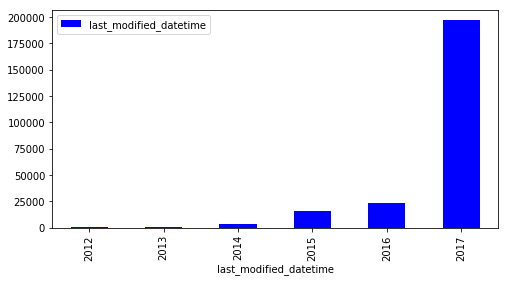

In [3]:
plt.rcParams["figure.figsize"] = (8,4)
df_dates = pd.to_datetime( df['last_modified_datetime'].dropna().drop(df[df['last_modified_datetime']=='en:france'].index)).reset_index().drop('index', axis=1)
df_dates = df_dates.groupby([df_dates["last_modified_datetime"].dt.year]).count()

plot = df_dates.plot(kind="bar", color = 'blue')

Results : both are overwhelmingly from 2017.
Though none are too old to be discarded or with invalid dates

## 2 - Looking at NutriScore distribution

<h3> 2.a - Nutrition score FR & UK distribution</h3>

The NutriScore is a good start to show healthiness of a product
<br>It is filled for 85% of our products list
<br>
<br>The lower the score, the healthier the product, acording to rules on this page :
<br>NutriScore calculation : https://fr.openfoodfacts.org/score-nutritionnel-experimental-france
<br>
<br>To summarize:
<br>    Bad components (like too many fats, sugar, salt) are raising the score
<br>    Good components (like fibers, proteins, fruits, vegetables) are lowering it 

Checking if a nutrition score is more usefull than the other


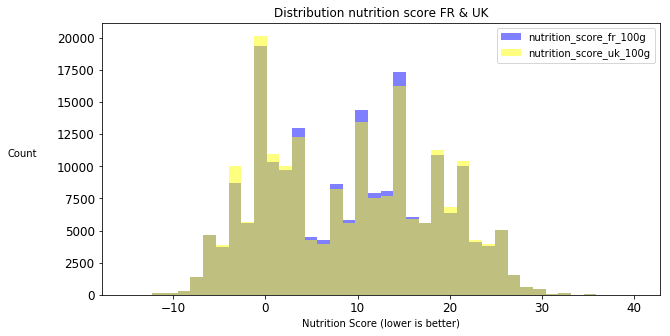

In [4]:
plt.rcParams["figure.figsize"] = (10,5)

print('Checking if a nutrition score is more usefull than the other')

df_plot_bar = df[['nutrition_score_fr_100g', 'nutrition_score_uk_100g']]
plot = df_plot_bar.plot.hist( bins= 40 
                      , alpha=0.5
                     ,title = 'Distribution nutrition score FR & UK'
                    ,fontsize = 12
                    , color=['blue', 'yellow']
                     )
plot = plt.ylabel('Count',rotation=0, labelpad=35)
plot = plt.xlabel ('Nutrition Score (lower is better)')

Result : Both FR & UK score are filled almost the same way
We'll use FR score going forward

<h3> 2.b - Nutrition grade repartition</h3>

In [5]:
color = ["bright green", "pale green", "pale yellow", "orange", "bright red"]
sns.set_palette(sns.xkcd_palette(color))
nutrigrade_colors= ["xkcd:bright green", "xkcd:pale green", "xkcd:pale yellow", "xkcd:orange", "xkcd:bright red"]

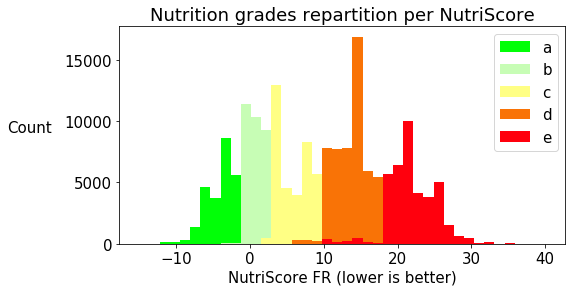

        Quantile note:
        99% of "A" grades have a score of -1.0 or below


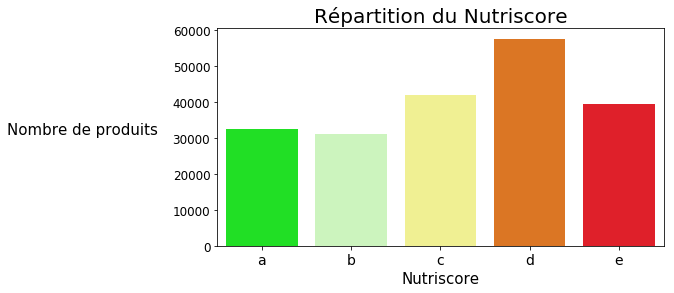

In [6]:
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams.update({'font.size': 15})
df_plot = pd.DataFrame()
for grade in enumerate('abcde'):
    df_grade = df[df['nutrition_grade_fr'] ==grade[1]]['nutrition_score_fr_100g']
    df_grade = df_grade.reset_index().drop('index', axis = 1)
    df_grade = df_grade.rename(columns = {'nutrition_score_fr_100g': grade[1]})
    df_plot = pd.concat([df_plot, df_grade], axis = 1, sort=True)
    
plot = df_plot.plot.hist(
     bins= 40
    ,title = 'Nutrition grades repartition per NutriScore'
   # , fontsize=15
    ,color =nutrigrade_colors
    
)

plot = plt.xlabel ('NutriScore FR (lower is better)', fontsize=15)
plot = plt.ylabel('Count',rotation=0, labelpad=35, fontsize=15)
plt.show()

ax = sns.countplot(x=df['nutrition_grade_fr'] , order= 'abcde')
silent=plt.xticks(fontsize=14)
silent=plt.yticks(fontsize=12)
silent = ax.set_title('Répartition du Nutriscore' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)
silent = ax.set_ylabel('Nombre de produits', rotation=0, labelpad=90, fontsize=15)

print( '        Quantile note:')
print( '        99% of "A" grades have a score of',df_plot['a'].dropna().quantile(.99),'or below')


In [7]:
df['nutrition_score_fr_100g'].describe()

count   202920.000000
mean         9.180786
std          9.055117
min        -15.000000
25%          1.000000
50%         10.000000
75%         16.000000
max         40.000000
Name: nutrition_score_fr_100g, dtype: float64

Results : Nutrition grades (abcde) are fairly well divided between our products
It is a good indicator of healthiness
Even though it is less precise, nutrition grades are clearer
I'll use Nutrition grade going forward

### 3 - Making a "healthy fats" products list

 #### 3.a - Analyzing saturated 'bad' fats
Saturated and trans fats are from Milk, cheeses, meat..
<br>They bad for health in general, their raise cholesterol level which increases risk of heart diseases.
<br>They should not exeed 10% of daily calories intake (30g for men, 20g for women)
<br>Source : www.gov.uk , Scientific Advisory Committee on Nutrition
<br>https://www.gov.uk/government/news/sacn-publishes-consultation-on-saturated-fats-and-health

        Impact of bad fats on NutriScore


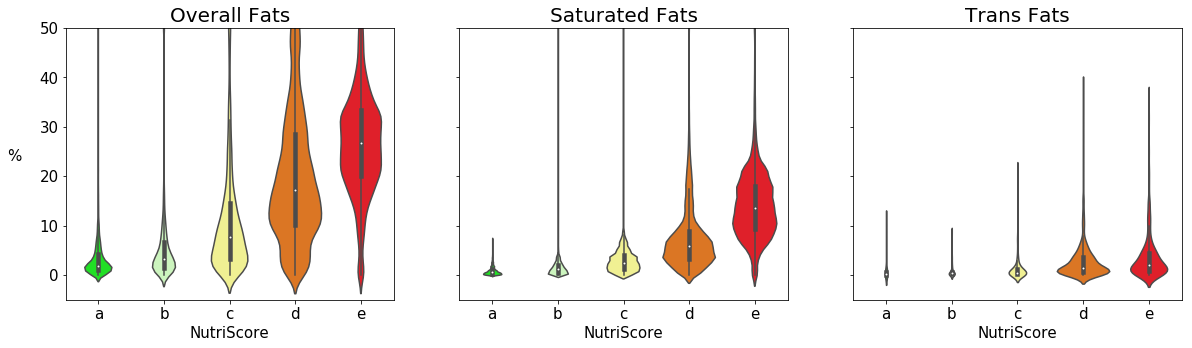

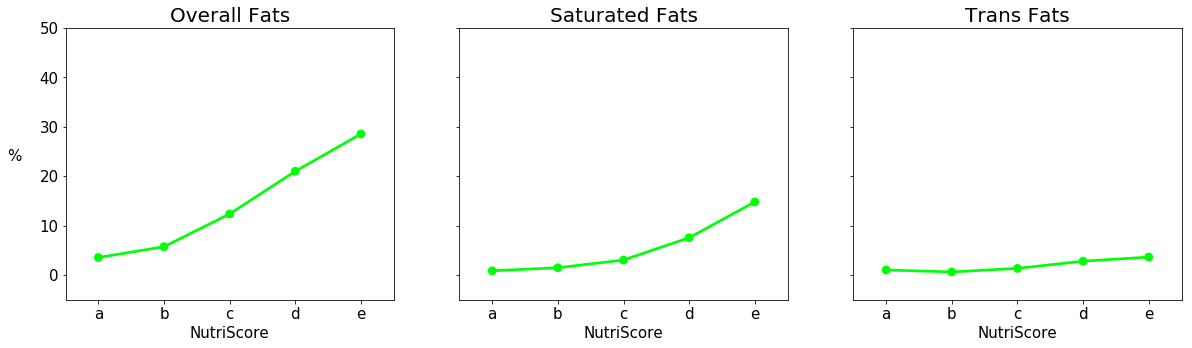

In [8]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)

print('        Impact of bad fats on NutriScore')

#1
ax = sns.violinplot('nutrition_grade_fr'
                    , 'fat_100g'
                    , data=df[df['fat_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , scale ='count'
                    , order= 'abcde'
                    )

silent = ax.set_title('Overall Fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)

silent = ax.set_ylim(-5, 50)


#2
ax = sns.violinplot('nutrition_grade_fr'
                    , 'saturated_fat_100g'
                    , data=df[df['saturated_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , scale ='count'
                    , order= 'abcde'
                   )
silent = ax.set_title('Saturated Fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


#3
ax = sns.violinplot('nutrition_grade_fr'
                    , 'trans_fat_100g'
                    , data=df[df['trans_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , scale ='count'
                    , order= 'abcde'
                   )

silent = ax.set_title('Trans Fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)

##############################

f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)

#1
ax = sns.pointplot('nutrition_grade_fr'
                    , 'fat_100g'
                    , data=df[df['fat_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , order= 'abcde'
                    )

silent = ax.set_title('Overall Fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)

silent = ax.set_ylim(-5, 50)


#2
ax = sns.pointplot('nutrition_grade_fr'
                    , 'saturated_fat_100g'
                    , data=df[df['saturated_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , order= 'abcde'
                   )
silent = ax.set_title('Saturated Fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


#3
ax = sns.pointplot('nutrition_grade_fr'
                    , 'trans_fat_100g'
                    , data=df[df['trans_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , order= 'abcde'
                   )

silent = ax.set_title('Trans Fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)





Results :
    A large amount of fats is usually correlated to a bad NutriScore
    The correlation is more pronounced for Saturated and Trans fats, which get almost no good grades

### 3.b - Unsaturated fats (good fats)
 <br>2 categories : <br><b>Polyunsaturated:</b> ( Like Omega-3, Omega-6 ) 
 <br>                    Found in Fish, corn, sunflower, nuts..
 <br>               <b>Monounsaturated: </b>
 <br>                    Found in Olive Oil, avocados, nuts...
 <br>

        Impact of good fats on NutriScore


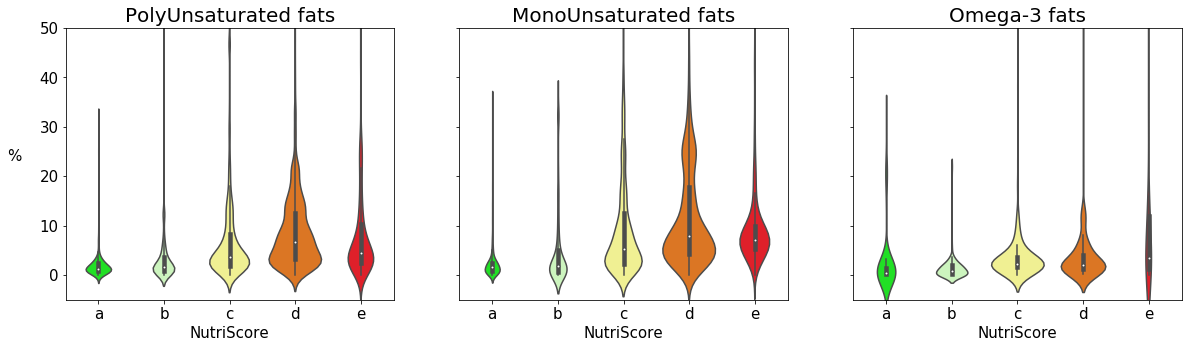

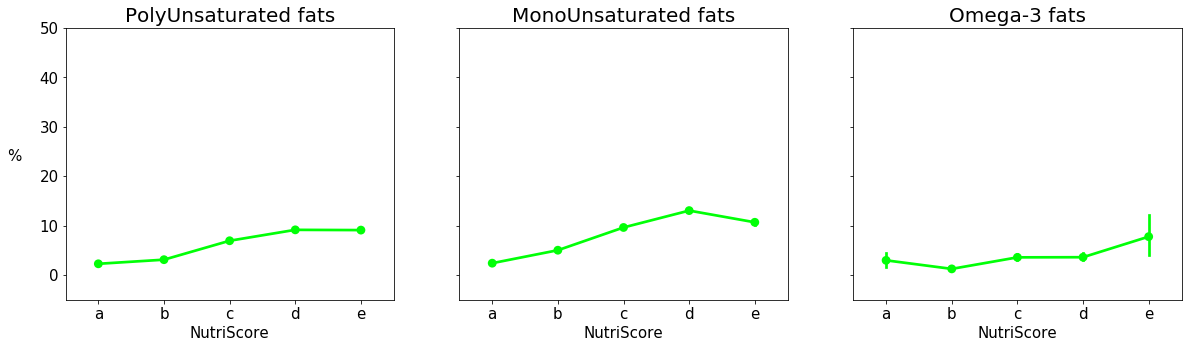

In [9]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)

print('        Impact of good fats on NutriScore')

#1
ax = sns.violinplot('nutrition_grade_fr'
                    , 'polyunsaturated_fat_100g'
                    , data=df[df['polyunsaturated_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , scale ='count'
                    , order= 'abcde'
                    )

silent = ax.set_title('PolyUnsaturated fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)

silent = ax.set_ylim(-5, 50)


#2
ax = sns.violinplot('nutrition_grade_fr'
                    , 'monounsaturated_fat_100g'
                    , data=df[df['monounsaturated_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , scale ='count'
                    , order= 'abcde'
                   )

silent = ax.set_title('MonoUnsaturated fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


#3
ax = sns.violinplot('nutrition_grade_fr'
                    , 'omega_3_fat_100g'
                    , data=df[df['omega_3_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , scale ='count'
                    , order= 'abcde'
                   )

silent = ax.set_title('Omega-3 fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


######################################

f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)
#1
ax = sns.pointplot('nutrition_grade_fr'
                    , 'polyunsaturated_fat_100g'
                    , data=df[df['polyunsaturated_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , order= 'abcde'
                    )

silent = ax.set_title('PolyUnsaturated fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)

silent = ax.set_ylim(-5, 50)


#2
ax = sns.pointplot('nutrition_grade_fr'
                    , 'monounsaturated_fat_100g'
                    , data=df[df['monounsaturated_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , order= 'abcde'
                   )

silent = ax.set_title('MonoUnsaturated fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


#3
ax = sns.pointplot('nutrition_grade_fr'
                    , 'omega_3_fat_100g'
                    , data=df[df['omega_3_fat_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , order= 'abcde'
                   )

silent = ax.set_title('Omega-3 fats' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)

##4
#ax = sns.pointplot('nutrition_grade_fr'
#                    , 'omega_6_fat_100g'
#                    , data=df[df['omega_6_fat_100g'] >0]
#                    , orient='v' 
#                    , ax=ax4
#                    , order= 'abcde'
#                    , cut =1
#                   )
#
#silent = ax.set_title('Omega-6 fats' ,  fontsize=20)
#silent = ax.set_xlabel('NutriScore',  fontsize=15)
#silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)





Results : Most products still end up in the D category (which is more represented)
<br> Bad grades are less correlated than with saturated fats.
<br> Though still it looks like more unsaturated fats means worse grades

#### 4.d - Comparing good fats and bad fats
<br>We'll add all good fats in one column
<br>All bad fats in another column
<br>We'll set a 'percent of good fats' column to show the correlation with a better grade

        Comparing Impacts of fats on NutriScore


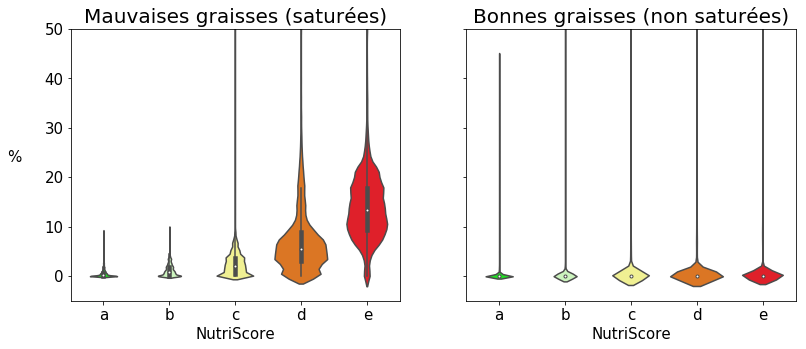

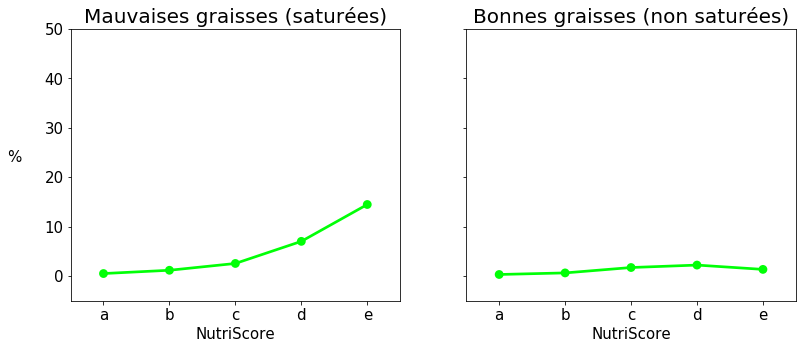

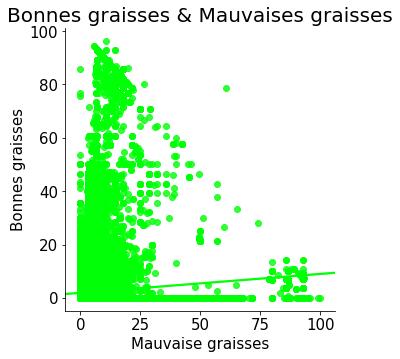

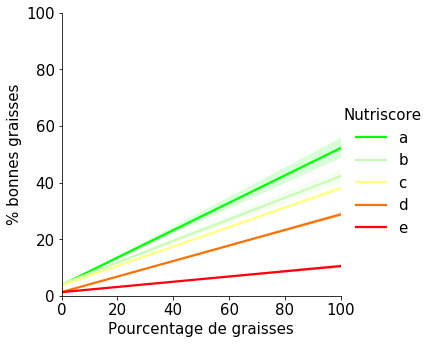

In [61]:


df_fats = df[['product_name'
              , 'saturated_fat_100g'
              ,'fat_100g'
              , 'nutrition_score_fr_100g'
              , 'nutrition_grade_fr'
              , 'omega_3_fat_100g' # (polyunsaturated group)
              , 'omega_6_fat_100g' # (polyunsaturated group)
              , 'omega_9_fat_100g' # Not enough products filled. Only 21
              , 'polyunsaturated_fat_100g'
              , 'monounsaturated_fat_100g'
              , 'trans_fat_100g' #Not many data, often 0
              , 'cholesterol_100g'  #Not many data, often 0
              ]][df['fat_100g'] >0]
df_fats['Good fats'] =  df_fats['polyunsaturated_fat_100g']+df_fats['monounsaturated_fat_100g']
df_fats['Bad fats'] =  df_fats['saturated_fat_100g']+df_fats['trans_fat_100g']

df_fats = df_fats[((df_fats['fat_100g']-df_fats['Good fats']) >0) & ((df_fats['fat_100g']-df_fats['Bad fats']) >0)] 

plt.rcParams["figure.figsize"] = (13,5)
f, (ax1,ax2) = plt.subplots(1, 2, sharey= True)


print('        Comparing Impacts of fats on NutriScore')

#1
ax = sns.violinplot('nutrition_grade_fr'
                    , 'Bad fats'
                    , data=df_fats
                    , orient='v' 
                    , ax=ax1
                    , scale ='count'
                    , order= 'abcde'
                   )
silent = ax.set_title('Mauvaises graisses (saturées)' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=30, fontsize=15)

silent = ax.set_ylim(-5, 50)



#2
ax = sns.violinplot('nutrition_grade_fr'
                    , 'Good fats'
                    , data=df_fats
                    , orient='v' 
                    , ax=ax2
                    , scale ='count'
                    , order= 'abcde'
                   )

silent = ax.set_title('Bonnes graisses (non saturées)',  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)

##############################

f, (ax1,ax2) = plt.subplots(1, 2, sharey= True)


#1
ax = sns.pointplot('nutrition_grade_fr'
                    , 'Bad fats'
                    , data=df_fats
                    , orient='v' 
                    , ax=ax1
                    , order= 'abcde'
                   )
silent = ax.set_title('Mauvaises graisses (saturées)' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=30, fontsize=15)


silent = ax.set_ylim(-5, 50)


#2
ax = sns.pointplot('nutrition_grade_fr'
                    , 'Good fats'
                    , data=df_fats
                    , orient='v' 
                    , ax=ax2
                    , order= 'abcde'
                   )

silent = ax.set_title('Bonnes graisses (non saturées)' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)

plt.show()



df_fats.loc[:, '% bonnes graisses'] = (df_fats['Good fats']/df_fats['fat_100g'] )*100
df_fats.loc[:, '% mauvaises graisses'] = (df_fats['Bad fats']/df_fats['fat_100g'] )*100

df_fats = df_fats.rename({'nutrition_grade_fr':'Nutriscore'}, axis =1)
df_fats = df_fats.rename({'fat_100g': 'Pourcentage de graisses'}, axis =1)

plt.rcParams["figure.figsize"] = (7,5)
ax = sns.lmplot(x='Bad fats', y ='Good fats', data=df_fats[(df_fats['Bad fats']+df_fats['Good fats']) >0],  ci  = 65)
axes = ax.axes
silent = axes[0,0].set_title('Bonnes graisses & Mauvaises graisses' ,  fontsize=20)
silent = axes[0,0].set_xlabel('Mauvaise graisses',  fontsize=15)
silent = axes[0,0].set_ylabel('Bonnes graisses',  fontsize=15)
plt.show()


plt.rcParams["figure.figsize"] = (20,5)
#1
ax = sns.lmplot('Pourcentage de graisses'
                    , '% bonnes graisses'
                    , data=df_fats
                   , hue='Nutriscore'
                    , ci  = 65
                ,scatter = False
                    , hue_order= 'abcde'
                    )

axes = ax.axes

silent =axes[0,0].set_ylim(0,100)
silent =axes[0,0].set_xlim(0,100)



In [11]:
print( 'Quantile note:')
quantile = df_fats[(df_fats['Nutriscore'] == 'e')].quantile(.10)['saturated_fat_100g']
print( '90% des produits gras notés E ont plus de ',quantile,'% d\'acides gras saturés')
quantile = df_fats[(df_fats['Nutriscore'] == 'd')| (df_fats['Nutriscore'] == 'e')].quantile(.10)['saturated_fat_100g'].round(3)
print( '90% des produits gras notés D ou E ont plus de ',quantile,'% d\'acides gras saturés')

Quantile note:
90% des produits gras notés E ont plus de  6.5 % d'acides gras saturés
90% des produits gras notés D ou E ont plus de  1.61 % d'acides gras saturés


Results: It appears that good fats in higher percent get better grades 
At least better grades than products High in bad fats

### 3.c - A 'Healthy Fats' products list
Even though large amount of fats (and saturated fats especially) is bad for health

<br>Some amount of fats is needed for energy
<br>And those fats in reasonable quantities are needed for a healthy diet

We will generate a healthy fats list based on products' fats composition, without using the nutriscore

### 3.d - A 'Healthy Fats' products list
Let's prepare criterias of healthy fats products from what we learned and from recommandations here : <br> https://www.health.qld.gov.au/__data/assets/pdf_file/0028/370756/paeds_foodlabels.pdf
Here https://www.eatforhealth.gov.au/sites/default/files/files/eatingwell/efh_food_label_example_130621.pdf
And here : https://www.bbcgoodfood.com/howto/guide/saturated-fat-facts

##### We're making 2 lists 

Products with acceptable/good fats :
    - They have at least one of the 'good fats' between 0.2 and 10 %
    - Or between 0.2% to 5% Global fats
    
Products with bad fats :
    - Less than 10% of fats total
    - Avoid trans fats completly : 0% 
    - Limit saturated fats 2% saturated fat

In [12]:
df_good_fats = df[( df['omega_6_fat_100g'].between(1, 10)  
                     | df['omega_3_fat_100g'].between(1,10) 
                     | df['monounsaturated_fat_100g'].between(1,10) 
                     | df['polyunsaturated_fat_100g'].between(1,10)
                     | df['fat_100g'].between(1,5)
                     )
                 ]
df_bad_fats = df[    ( df['trans_fat_100g'] >0.01 )
                     |( df['saturated_fat_100g'] >2)
                     |( df['fat_100g'] >10 )
                     
                    ] 
df_healthy_fats = df_good_fats[~df_good_fats.isin(df_bad_fats)] #.dropna(how='all')


print(df_healthy_fats.count().max(), 'products found with healthy fats.')
print('Here are some exemples')
df_healthy_fats[['product_name', 'fat_100g','saturated_fat_100g', 'monounsaturated_fat_100g','polyunsaturated_fat_100g','omega_3_fat_100g','omega_6_fat_100g']].sample(3)

36297 products found with healthy fats.
Here are some exemples


,product_name,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,omega_6_fat_100g
63923,Thai Rice Stir-Fry Noodles,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
86265,NaN,nan,nan,nan,nan,nan,nan
88792,NaN,nan,nan,nan,nan,nan,nan


#### Checking Nutrigrade repartition for healthy fats

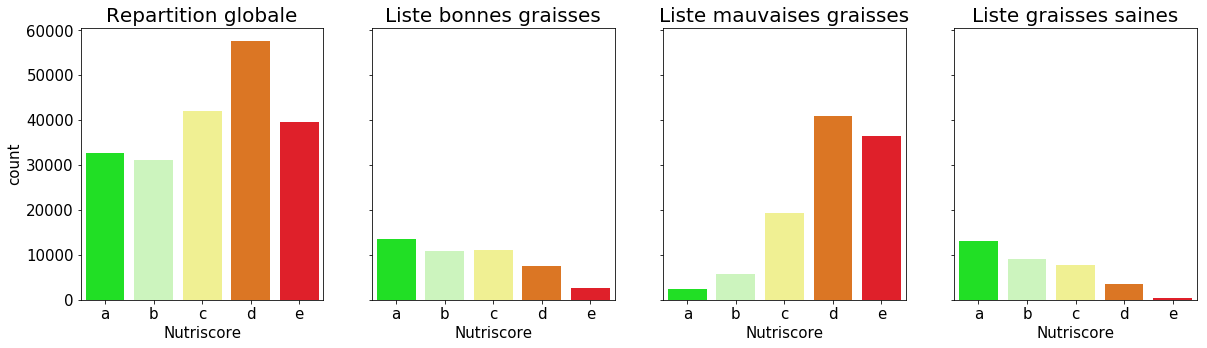

In [13]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, sharey= True)

ax = sns.countplot(x=df['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Repartition globale' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

ax = sns.countplot(x=df_good_fats['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Liste bonnes graisses' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


ax = sns.countplot(x=df_bad_fats['nutrition_grade_fr'] , ax = ax3 , order= 'abcde')
silent = ax.set_title('Liste mauvaises graisses' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)

ax = sns.countplot(x=df_healthy_fats['nutrition_grade_fr'] , ax = ax4 , order= 'abcde')
silent = ax.set_title('Liste graisses saines' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)


##### Results 
Almost no 'E' grades, but some 'D' grades.
Good grades on average but some healthy fats products probably have some other bad components

## 4 - Making a "healthy carbs" products list

<h3> 4.a - Analyzing the data</h3>

<br>Sugars are part of the carbohydrates, which also include fibers and starches.
<br>Starch (amidon) are good for health in its 'resistant' form (Starch are found potatoes, bread, pasta, beans)
<br>Fiber is not broken down into sugars when digested. Very low glycemic index.
<br>
<br>Sugars calories intake recommendation is 5% or less (30g/day for adults) 
<br>Accorging to SACN on www.gov.uk
<br>https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/489906/Why_5__-_The_Science_Behind_SACN.pdf

        Impact of sugars on NutriScore


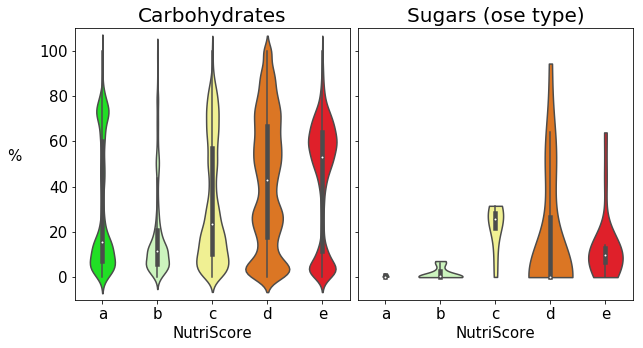

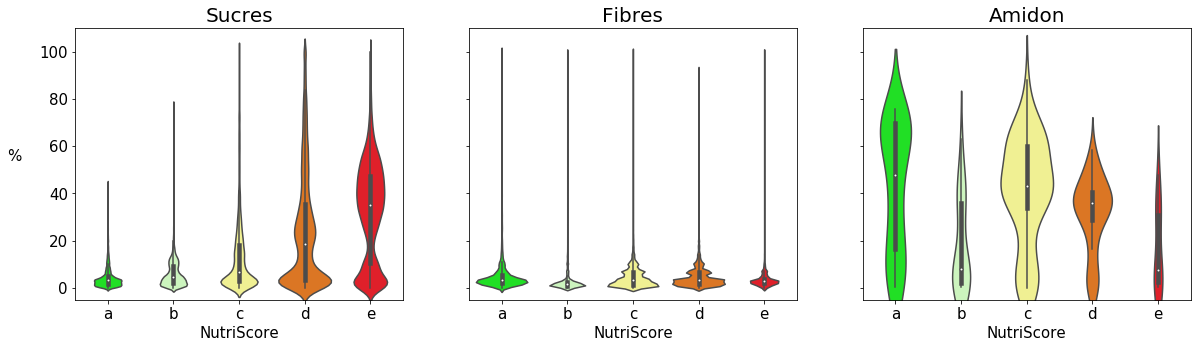

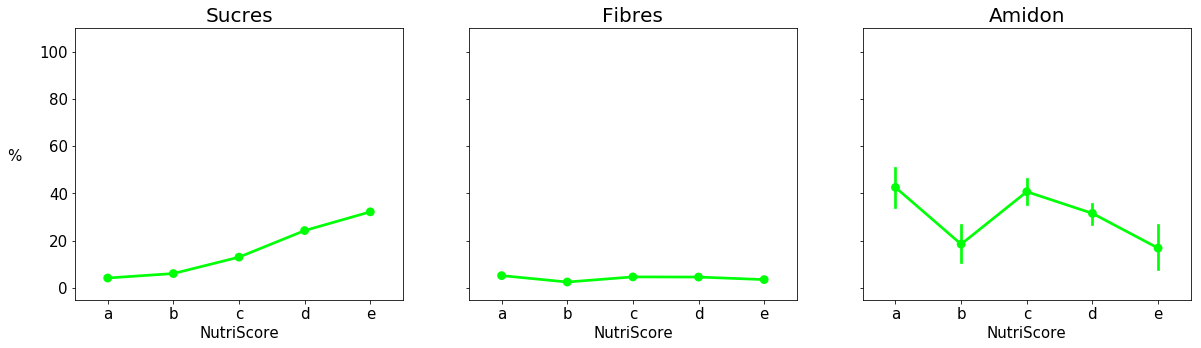

In [14]:

plt.rcParams["figure.figsize"] = (10,5)
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.03, hspace=0.15) # set the spacing between axes. 

ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
silent = ax1.set_ylim([-10, 110])
silent = ax2.set_ylim([-10, 110])

pd.options.mode.chained_assignment = None  # default='warn'
df['other_sugars_100g'] = (
                       df['sucrose_100g']
                      +df['glucose_100g'] 
                      +df['fructose_100g']
                      +df['lactose_100g']
                      +df['maltose_100g']
                      +df['maltodextrins_100g']
                               )
                

print('        Impact of sugars on NutriScore')

#1
ax = sns.violinplot('nutrition_grade_fr'
                    , 'carbohydrates_100g'
                    , data=df[df['carbohydrates_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , scale ='count'
                    , order= 'abcde'
                    )

silent = ax.set_title('Carbohydrates' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)
ticklabels = ax.get_yticklabels()

#2
ax = sns.violinplot('nutrition_grade_fr'
                    , 'other_sugars_100g'
                    , data=df[df['other_sugars_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , scale ='count'
                    , order= 'abcde'
                    , cut = 0
                   )

silent = ax.set_title('Sugars (ose type)' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])


plt.show()
plt.cla()
plt.clf()
plt.close()
########## NEW ROW


plt.rcParams["figure.figsize"] = (20,5)
gs1 = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])

silent = ax1.set_ylim([-5, 110])
silent = ax2.set_ylim([-5, 110])
silent = ax3.set_ylim([-5, 110])

#1

ax = sns.violinplot('nutrition_grade_fr'
                    , 'sugars_100g'
                    , data=df[df['sugars_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , scale ='count'
                    , order= 'abcde'
                   )
silent = ax.set_title('Sucres' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)


#2
ax = sns.violinplot('nutrition_grade_fr'
                    , 'fiber_100g'
                    , data=df[df['fiber_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , scale ='count'
                    , order= 'abcde'
                   )
silent = ax.set_title('Fibres' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])

#3
ax = sns.violinplot('nutrition_grade_fr'
                    , 'starch_100g'
                    , data=df[df['starch_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , scale ='count'
                    , order= 'abcde'
                   )
silent = ax.set_title('Amidon' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])



plt.show()
plt.cla()
plt.clf()
plt.close()
########### NEW ROW


plt.rcParams["figure.figsize"] = (20,5)
gs1 = gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])

silent = ax1.set_ylim([-5, 110])
silent = ax2.set_ylim([-5, 110])
silent = ax3.set_ylim([-5, 110])


#1

ax = sns.pointplot('nutrition_grade_fr'
                    , 'sugars_100g'
                    , data=df[df['sugars_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , order= 'abcde'
                   )
silent = ax.set_title('Sucres' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)


#2
ax = sns.pointplot('nutrition_grade_fr'
                    , 'fiber_100g'
                    , data=df[df['fiber_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , order= 'abcde'
                   )
silent = ax.set_title('Fibres' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])

#3
ax = sns.pointplot('nutrition_grade_fr'
                    , 'starch_100g'
                    , data=df[df['starch_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , order= 'abcde'
                   )
silent = ax.set_title('Amidon' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])


###  4.b - Observations on carbs
We can see that carbohydrates are especially bad when in the form of sugars or fructose, lactose...

Starch are mostly synonym of a good nutriscore, even in large amount (mostly found in bread products)
Fibers have average grades but should be recommended as they are often consumed in too small quantities

### 4.c - 'Healthy carbs' products rules
Let's prepare a list of healthy sugars products 
    - They'll need to have at least one good sugar source (starch or fiber)
    - No more than 3% regular sugar, glucose, fructose, lactose
    - No more than 75% carbs

In [15]:
df_good_carbs = df[(df['fiber_100g'] >0.5)
                     | (df['starch_100g'] >1)
                    ]

df_bad_carbs = df[(df['sugars_100g']
                      +df['sucrose_100g']
                      +df['glucose_100g']
                      +df['fructose_100g'] 
                      +df['lactose_100g'] >=5
                  )
                  | (df['carbohydrates_100g'] > 75)
                    ] 

df_healthy_carbs  = df_good_carbs[~df_good_carbs.isin(df_bad_carbs)].dropna(how='all')

print(df_healthy_carbs.count().max(), 'products found with healthy carbs.')
print('Here are some exemples')
df_healthy_carbs[['product_name'
              , 'carbohydrates_100g' 
              , 'sugars_100g'
              , 'nutrition_score_fr_100g'
              , 'nutrition_grade_fr'
              , 'starch_100g' #amidon
              , 'fiber_100g'
              , 'sucrose_100g'
              , 'glucose_100g'
              , 'fructose_100g'
              , 'lactose_100g'
              ]].sample(5)

52729 products found with healthy carbs.
Here are some exemples


,product_name,carbohydrates_100g,sugars_100g,nutrition_score_fr_100g,nutrition_grade_fr,starch_100g,fiber_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g
164058,Cassegrain Lentilles Cuisinées,11.700000,0.000000,-5.000000,a,0.000000,4.300000,0.000000,0.000000,0.000000,0.000000
196851,"Pavé de Saumon, Sauce à l'oseille et ses Pâtes...",5.000000,1.500000,0.000000,b,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
68935,Whole Wheat Smart Thins,51.160000,4.650000,-3.000000,a,0.000000,11.600000,0.000000,0.000000,0.000000,0.000000
38379,Chunky Soup,8.980000,2.040000,2.000000,b,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000
55623,Mixes Beans,62.220000,2.220000,-6.000000,a,0.000000,17.800000,0.000000,0.000000,0.000000,0.000000


<h3> 4.d - Crossing our results

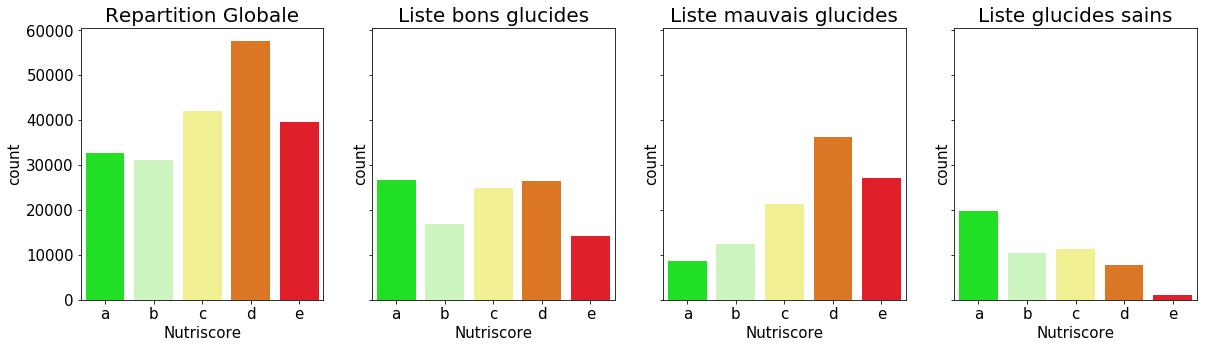

In [16]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, sharey= True)

ax = sns.countplot(x=df['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Repartition Globale' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

ax = sns.countplot(x=df_good_carbs['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Liste bons glucides' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)


ax = sns.countplot(x=df_bad_carbs['nutrition_grade_fr'] , ax = ax3 , order= 'abcde')
silent = ax.set_title('Liste mauvais glucides' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

ax = sns.countplot(x=df_healthy_carbs['nutrition_grade_fr'] , ax = ax4 , order= 'abcde')
silent = ax.set_title('Liste glucides sains' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

<h3> 4.e - Crossing results between Fats and Carbs

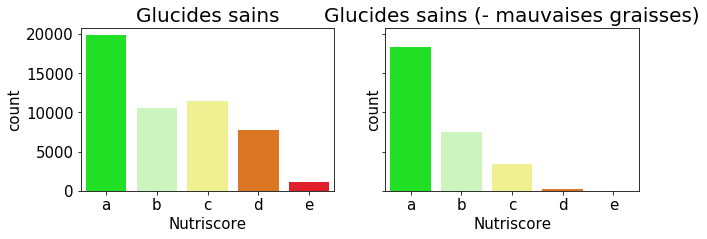

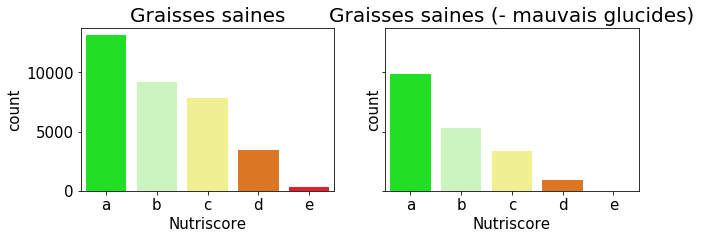

In [17]:
plt.rcParams["figure.figsize"] = (10,3)
f, (ax1,ax2) = plt.subplots(1, 2, sharey= True)


ax = sns.countplot(x=df_healthy_carbs['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Glucides sains' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

df_healthy_carbs  = df_healthy_carbs[~df_healthy_carbs.isin(df_bad_fats)].dropna(how='all')

ax = sns.countplot(x=df_healthy_carbs['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Glucides sains (- mauvaises graisses)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)


f, (ax1,ax2) = plt.subplots(1, 2, sharey= True)

ax = sns.countplot(x=df_healthy_fats['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Graisses saines' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

df_healthy_fats  = df_healthy_fats[~df_healthy_fats.isin(df_bad_carbs)].dropna(how='all')

ax = sns.countplot(x=df_healthy_fats['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Graisses saines (- mauvais glucides)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

#### 4.f - Results
Not bad results ! 
We see no E grades and almost no D grades in our lists, with low C grades
This is after removing both Bad fats and Bad carbs lists.

With still have a few D grades in the Healthy fats list though. Let's dig further

### 5 - Salt & Additives
#### 5.a - Analyzing 

Too much salt/sodium is bad for health as it increases blood pressure.
<br>Additives are usually harmless and often natural. 
<br>However authorized list of additives can vary between regulated countries.
<br>Therefore there is always some controversy on some additives.

<br>Controversial additives list found on various internet links

        Impact of salts and additives on NutriScore


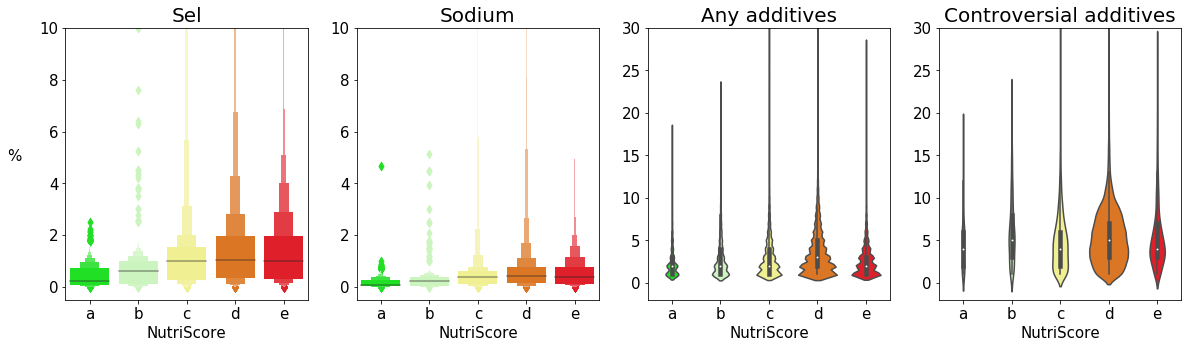

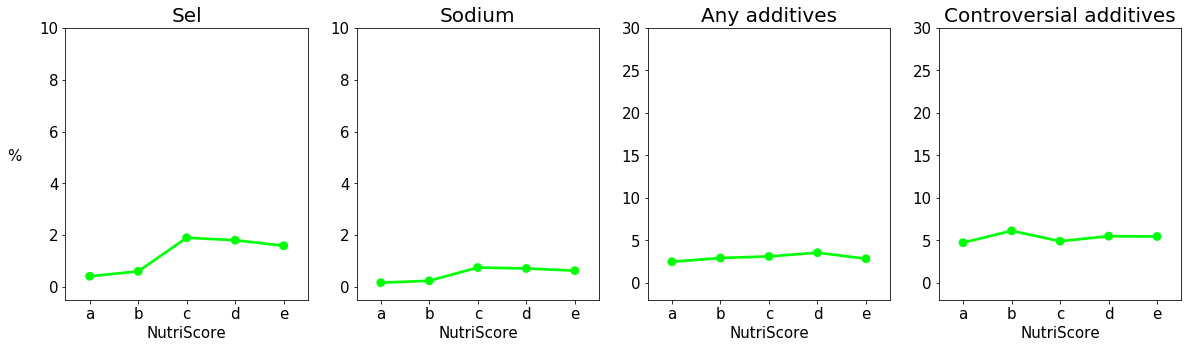

In [18]:
plt.rcParams["figure.figsize"] = (20,5)

df['additives_tags'] = df['additives_tags'].fillna('')

controversial_additives = ['e221', 'e133', 'e124', 'e110', 'e102' , 'e621', 'e320', 'e220', 'e951']
df_additives = df[df['additives_tags'].str.contains('|'.join(controversial_additives))]


print('        Impact of salts and additives on NutriScore')

f, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, sharey= False)
#1
ax = sns.boxenplot('nutrition_grade_fr'
                    , 'salt_100g'
                    , data=df[df['salt_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , order= 'abcde'
                    )

silent = ax.set_title('Sel' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)
silent = ax.set_ylim([-0.5, 10])



#2
ax = sns.boxenplot('nutrition_grade_fr'
                    , 'sodium_100g'
                    , data=df[df['sodium_100g'] >0]
                    , ax=ax2
                    , orient='v' 
                    , order= 'abcde'
                   )

silent = ax.set_title('Sodium' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', labelpad=25, fontsize=15)
silent = ax.set_ylim([-0.5, 10])


#3
ax = sns.violinplot('nutrition_grade_fr'
                    , 'additives_n'
                    , data=df[df['additives_n'] >0]
                    , orient='v' 
                    , ax=ax3
                    , scale ='count'
                    , order= 'abcde'
                   )

silent = ax.set_title('Any additives' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_ylim([-2, 30])

#4
ax = sns.violinplot('nutrition_grade_fr'
                    , 'additives_n'
                    , data=df_additives[df_additives['additives_n'] >0]
                    , orient='v' 
                    , ax=ax4
                    , scale ='count'
                    , order= 'abcde'
                   )

silent = ax.set_title('Controversial additives' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_ylim([-2, 30])




plt.show()
plt.cla()
plt.clf()
plt.close()
########### NEW ROW

f, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, sharey= False)
#1
ax = sns.pointplot('nutrition_grade_fr'
                    , 'salt_100g'
                    , data=df[df['salt_100g'] >0]
                    , orient='v' 
                    , ax=ax1
                    , order= 'abcde'
                    , cut = 0
                    )

silent = ax.set_title('Sel' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)
silent = ax.set_ylim([-0.5, 10])



#2
ax = sns.pointplot('nutrition_grade_fr'
                    , 'sodium_100g'
                    , data=df[df['sodium_100g'] >0]
                    , ax=ax2
                    , orient='v' 
                    , order= 'abcde'
                    , cut = 0
                   )

silent = ax.set_title('Sodium' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', labelpad=25, fontsize=15)
silent = ax.set_ylim([-0.5, 10])


#3
ax = sns.pointplot('nutrition_grade_fr'
                    , 'additives_n'
                    , data=df[df['additives_n'] >0]
                    , orient='v' 
                    , ax=ax3
                    , order= 'abcde'
                   )

silent = ax.set_title('Any additives' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_ylim([-2, 30])

#4
ax = sns.pointplot('nutrition_grade_fr'
                    , 'additives_n'
                    , data=df_additives[df_additives['additives_n'] >0]
                    , orient='v' 
                    , ax=ax4
                    , order= 'abcde'
                   )

silent = ax.set_title('Controversial additives' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_ylim([-2, 30])




plt.show()
plt.cla()
plt.clf()
plt.close()


### 5.b Removing Salt and bad additives from our lists of healthy products
<br>
<br>Bad products 
<br>Sodium >0.4%
<br>Salt >0.8%
<br>Any of the 9 listed controversial additives
<br>
Sodium must be limited to 400mg (salt equivalent is around double that amount)
<br>https://www.eatforhealth.gov.au/sites/default/files/files/eatingwell/efh_food_label_example_130621.pdf

In [19]:
df_salty = df[(df['salt_100g']>0.8) | (df['sodium_100g']>0.4)]

25633  healthy carbs before removing additives
25295  healthy carbs after removing additives
11891  healthy fats before removing additives
11696  healthy fats after removing additives


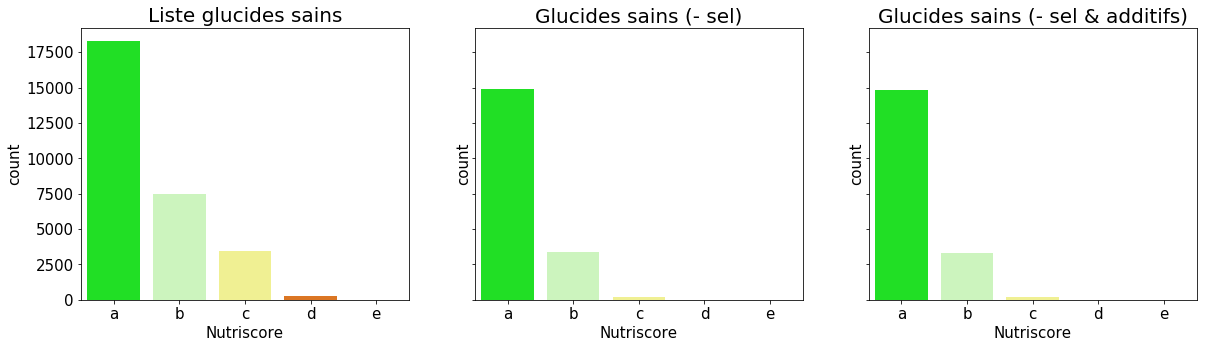

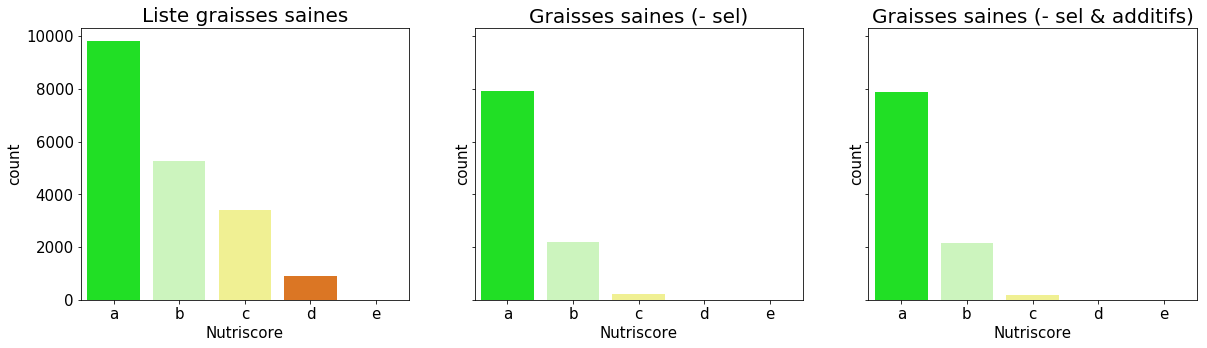

In [20]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)


ax = sns.countplot(x=df_healthy_carbs['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Liste glucides sains' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

df_healthy_carbs  = df_healthy_carbs[~df_healthy_carbs.isin(df_salty)].dropna(how='all')

ax = sns.countplot(x=df_healthy_carbs['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Glucides sains (- sel)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

print(df_healthy_carbs.shape[0], ' healthy carbs before removing additives')
df_healthy_carbs  = df_healthy_carbs[~df_healthy_carbs.isin(df_additives)].dropna(how='all')
print(df_healthy_carbs.shape[0], ' healthy carbs after removing additives')

ax = sns.countplot(x=df_healthy_carbs['nutrition_grade_fr'] , ax = ax3 , order= 'abcde')
silent = ax.set_title('Glucides sains (- sel & additifs)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)



f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)

ax = sns.countplot(x=df_healthy_fats['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Liste graisses saines' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

df_healthy_fats  = df_healthy_fats[~df_healthy_fats.isin(df_salty)].dropna(how='all')

ax = sns.countplot(x=df_healthy_fats['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Graisses saines (- sel)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

print(df_healthy_fats.shape[0], ' healthy fats before removing additives')
df_healthy_fats  = df_healthy_fats[~df_healthy_fats.isin(df_additives)].dropna(how='all')
print(df_healthy_fats.shape[0], ' healthy fats after removing additives')

ax = sns.countplot(x=df_healthy_fats['nutrition_grade_fr'] , ax = ax3 , order= 'abcde')
silent = ax.set_title('Graisses saines (- sel & additifs)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)


### 5.c - Other products (no fat, no sugar). This list will not be used
<br> We're trying to see how many 'good' products are in none of our previous lists
<br> Not so many compared to our lists above

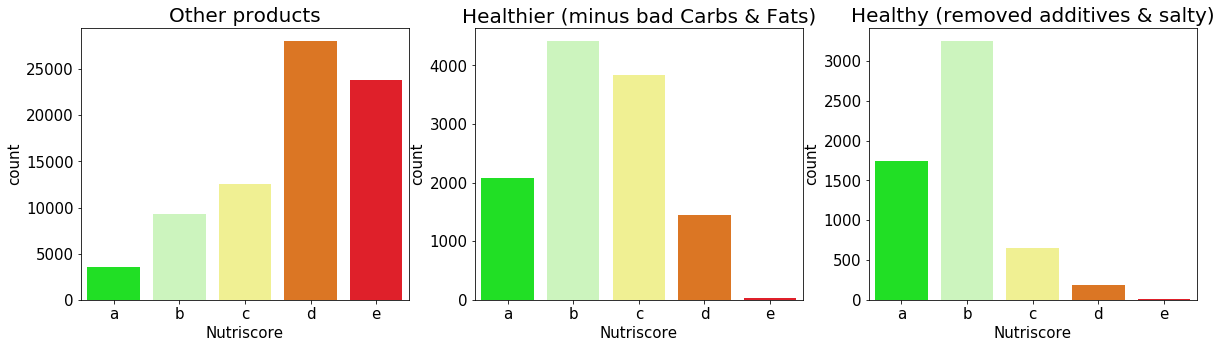

In [21]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= False)

df_healthy_products = df[~df.isin(df_good_fats)].dropna(how='all')
df_healthy_products = df_healthy_products[~df_healthy_products.isin(df_good_carbs)].dropna(how='all')


ax = sns.countplot(x=df_healthy_products['nutrition_grade_fr'] , ax = ax1 , order= 'abcde')
silent = ax.set_title('Other products' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

df_healthy_products = df_healthy_products[~df_healthy_products.isin(df_bad_carbs)].dropna(how='all')
df_healthy_products = df_healthy_products[~df_healthy_products.isin(df_bad_fats)].dropna(how='all')

ax = sns.countplot(x=df_healthy_products['nutrition_grade_fr'] , ax = ax2 , order= 'abcde')
silent = ax.set_title('Healthier (minus bad Carbs & Fats)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)

df_healthy_products = df_healthy_products[~df_healthy_products.isin(df_additives)].dropna(how='all')
df_healthy_products = df_healthy_products[~df_healthy_products.isin(df_salty)].dropna(how='all')

ax = sns.countplot(x=df_healthy_products['nutrition_grade_fr'] , ax = ax3 , order= 'abcde')
silent = ax.set_title('Healthy (removed additives & salty)' ,  fontsize=20)
silent = ax.set_xlabel('Nutriscore',  fontsize=15)



Exemple of products not in our lists

In [22]:
df_healthy_products[df_healthy_products['nutrition_grade_fr'] =='a'].sample(5)

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,energy_from_fat_100g,fat_100g,saturated_fat_100g,caprylic_acid_100g,capric_acid_100g,lauric_acid_100g,myristic_acid_100g,palmitic_acid_100g,stearic_acid_100g,arachidic_acid_100g,behenic_acid_100g,montanic_acid_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,omega_3_fat_100g,alpha_linolenic_acid_100g,eicosapentaenoic_acid_100g,docosahexaenoic_acid_100g,omega_6_fat_100g,linoleic_acid_100g,arachidonic_acid_100g,gamma_linolenic_acid_100g,dihomo_gamma_linolenic_acid_100g,omega_9_fat_100g,oleic_acid_100g,gondoic_acid_100g,trans_fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum_proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin_a_100g,beta_carotene_100g,vitamin_d_100g,vitamin_e_100g,vitamin_k_100g,vitamin_c_100g,vitamin_b1_100g,vitamin_b2_100g,vitamin_pp_100g,vitamin_b6_100g,vitamin_b9_100g,folates_100g,vitamin_b12_100g,biotin_100g,pantothenic_acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits_vegetables_nuts_100g,collagen_meat_protein_ratio_100g,cocoa_100g,carbon_footprint_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,code,product_name,brands,categories,last_modified_datetime,categories_tags,labels_fr,countries_fr,ingredients_text,allergens,additives_tags,additives_fr,nutrition_grade_fr,main_category,main_category_fr,other_sugars_100g
174430,0.000000,0.000000,0.000000,1569.000000,0.000000,0.000000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.080000,0.031496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3251750000247,Craquelin,Christian Margely,,2017-03-04T12:37:48Z,,,France,,,,,a,,,0.000000
154126,0.000000,0.000000,0.000000,226.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.870000,0.000000,0.000000,0.000000,0.414020,0.163000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,-4.000000,119578,"Break Free, 100% Liquid Egg White",Kroger,,2017-03-09T14:19:00Z,,,États-Unis,100% liquid egg whites,,,,a,,,0.000000
50697,3.000000,0.000000,0.000000,280.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

Notes : Some have less than 1% fats

### 5.d - Proteins
<br>We need between 40 and 80 grams of proteins per day

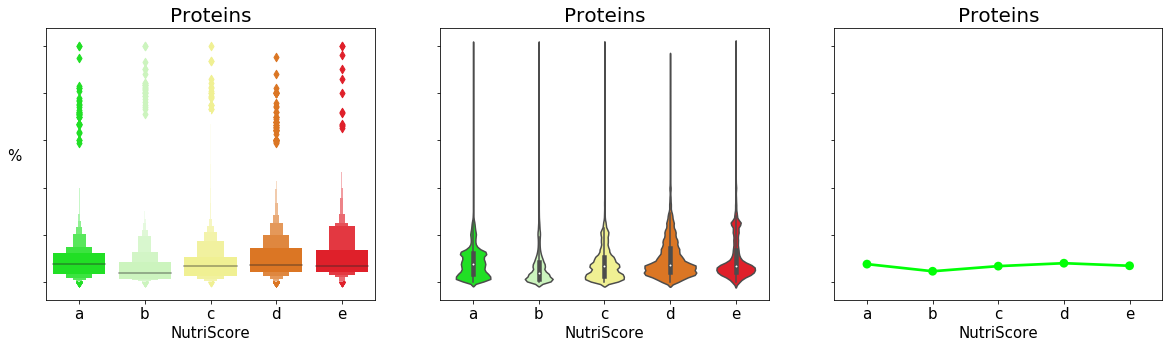

In [23]:
plt.rcParams["figure.figsize"] = (20,5)

f, (ax1,ax2, ax3) = plt.subplots(1, 3, sharey= True)

#1
ax = sns.boxenplot('nutrition_grade_fr'
                    , 'proteins_100g'
                    , data=df[df['proteins_100g'] >0]
                    , orient='v' 
                    , order= 'abcde'
                    , ax=ax1
                    )

silent = ax.set_title('Proteins' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('%', rotation=0, labelpad=25, fontsize=15)
#2
ax = sns.violinplot('nutrition_grade_fr'
                    , 'proteins_100g'
                    , data=df[df['proteins_100g'] >0]
                    , orient='v' 
                    , ax=ax2
                    , scale ='count'
                    , order= 'abcde'
                   )
silent = ax.set_title('Proteins' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])

#3

ax = sns.pointplot('nutrition_grade_fr'
                    , 'proteins_100g'
                    , data=df[df['sugars_100g'] >0]
                    , orient='v' 
                    , ax=ax3
                    , order= 'abcde'
                   )
silent = ax.set_title('Proteins' ,  fontsize=20)
silent = ax.set_xlabel('NutriScore',  fontsize=15)
silent = ax.set_ylabel('', rotation=0, labelpad=0, fontsize=15)
silent = ax.set_yticklabels([])

#2



<br>Proteins do not appear to correlate directly to a good score. 
<br>Though between 40 and 80 grams of proteins per day are needed 

<br> 
<br>Given that it's a single metric, we won't create a new list.
<br>We'll include it in the HEalth score

## 6 - Ordering products by vitamin, metals & protein score

Basically all metals and vitamins are good for a healthy diet.
But they are too many to have a look at them independently.

We can found EU vitamin & metals requirements in this doc (p44) https://eur-lex.europa.eu/LexUriServ/LexUriServ.do?uri=OJ:L:2011:304:0018:0063:FR:PDF

Problem : Some products are not correctly labeled and therefore we find unreal percent of metals & vitamins.
Exemples of products indicated in grams instead of milligrams (1000x more!)
https://fr.openfoodfacts.org/produit/8430236271202/maiz-dulce-fresco-en-mazorca-surinver
https://fr.openfoodfacts.org/produit/3428274140029/milk-ngo-lactel

We will therefore score 1 point per type of metal & vitamin present in each product


### 6.a Calculating score

<br>We'll add 1 point per different vitamin present
<br>We'll add 1 point per different metal present
<br>We'll add between 2 to 6 points per amount of protein (between 1% and 25%)

In [24]:
metal_columns = ['potassium_100g','calcium_100g','chloride_100g','phosphorus_100g'
,'iron_100g','magnesium_100g','zinc_100g', 'iodine_100g'
,'copper_100g','manganese_100g', 'fluoride_100g', 'selenium_100g', 'chromium_100g'
]
df.loc[:, 'metal_score'] = 0

for column in metal_columns:
    df.loc[df[column] > 0 , 'metal_score'] = df['metal_score']+1


#Vitamins 
column_like ='vitamin'
vitamin_column = df.filter(like = column_like).columns
df.loc[:, 'vitamin_score'] = 0
for column in vitamin_column:
    df.loc[df[column] > 0 , 'vitamin_score'] = df['vitamin_score']+1

df['metal_vitamin_score'] = (df['vitamin_score']+df['metal_score'] )

df['health_score'] = df['metal_vitamin_score']
df.loc[df['proteins_100g'].between(1,5) , 'health_score']  =df['health_score']+2
df.loc[df['proteins_100g'].between(5.01,10) , 'health_score']  =df['health_score']+4
df.loc[df['proteins_100g'].between(10.01,15) , 'health_score']  =df['health_score']+6
df.loc[df['proteins_100g'].between(15.01,20) , 'health_score']  =df['health_score']+4
df.loc[df['proteins_100g'].between(20.01,25) , 'health_score']  =df['health_score']+2

In [25]:
#Adding our new score columns to existing lists
df_healthy_fats = df.loc[df_healthy_fats.index]
df_healthy_carbs = df.loc[df_healthy_carbs.index]

### 6.b - Scores repartition

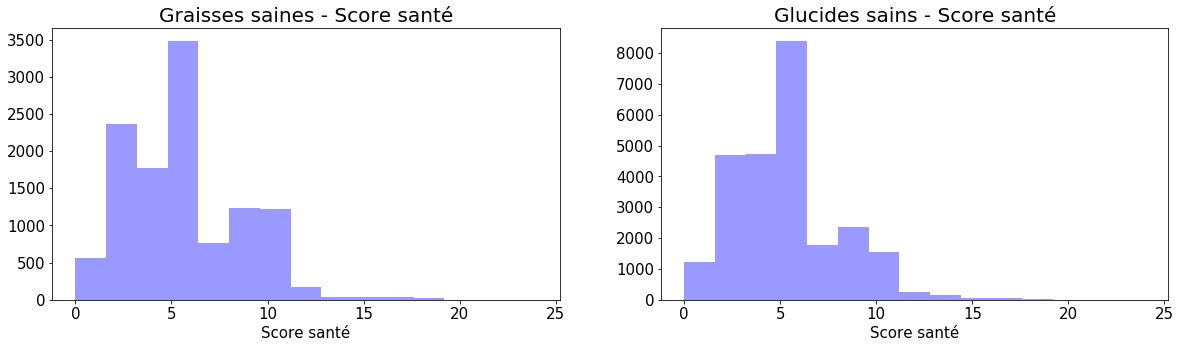

In [26]:
plt.rcParams["figure.figsize"] = (20,5)
f, (ax1,ax2) = plt.subplots(1, 2, sharey= False)

ax = sns.distplot(df_healthy_fats['health_score'], bins =15, kde=False, color = 'blue', ax = ax1)
silent = ax.set_title('Graisses saines - Score santé' ,  fontsize=20)
silent = ax.set_xlabel('Score santé',  fontsize=15)


ax = sns.distplot(df_healthy_carbs['health_score'], bins =15, kde=False, color = 'blue', ax = ax2)
silent = ax.set_title('Glucides sains - Score santé' ,  fontsize=20)
silent = ax.set_xlabel('Score santé',  fontsize=15)


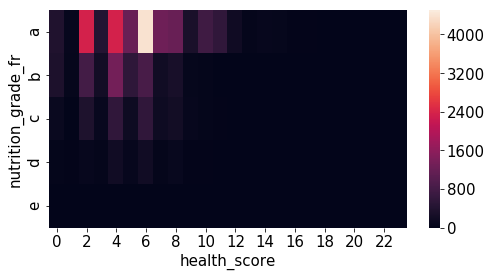

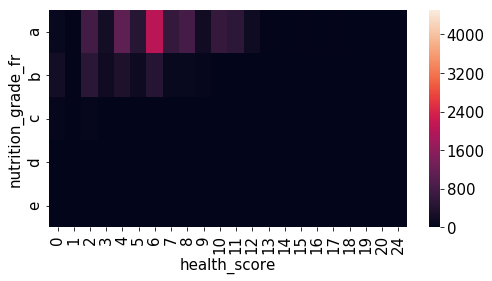

In [40]:

plt.rcParams["figure.figsize"] = (8,4)
df_heat = df_healthy_carbs.groupby(['nutrition_grade_fr','health_score']).size().reset_index(name='counts')

df_heat_2 =  df_heat.pivot_table(values='counts', index=df_heat.nutrition_grade_fr, columns='health_score', aggfunc='first')
df_heat_2 = df_heat_2.fillna(0)
sns.heatmap(df_heat_2 ,vmin=0, vmax=4500)

plt.show()
plt.rcParams["figure.figsize"] = (8,4)
df_heat = df_healthy_fats.groupby(['nutrition_grade_fr','health_score']).size().reset_index(name='counts')

df_heat_2 =  df_heat.pivot_table(values='counts', index=df_heat.nutrition_grade_fr, columns='health_score', aggfunc='first')
df_heat_2 = df_heat_2.fillna(0)
sns.heatmap(df_heat_2 ,vmin=0, vmax=4500)


## 7 - Final lists of healthy products

Now that we have our final lists, we can check in details what kind of products we have

### 7.a - Carbs list

In [ ]:
final_columns = ['code', 'product_name', 'brands','categories_tags','main_category', 'ingredients_text'
                 , 'nutrition_grade_fr', 'health_score', 'proteins_100g', 'fat_100g'
                ,'carbohydrates_100g', 'sugars_100g'
                ]

df_healthy_carbs[final_columns].sort_values(by=['health_score'], ascending=False).head(5)

The first product in this list has an E nutrition grade, which is odd.
<br> Though looking further why that is, it's not correctly filled.
<br> When going to the page of the product, it shows a B grade.
<br> https://fr.openfoodfacts.org/produit/3245412478864/milk-shake-substitut-de-repas-saveur-chocolat-x-3-agir-carrefour-nutrition

We mostly see protein shakes and meal substitutes/suplements at the top of our carbs list
<br>Even though we removed those categories in the cleaning.
<br>The shakes often don't have a category filled

In [ ]:

carbs_top250 = df_healthy_carbs[final_columns].fillna('x').sort_values(by=['health_score'], ascending=False).head(250)
#df_top100 = df_top100.append(df_healthy_fats[final_columns].fillna('x').sort_values(by=['health_score'], ascending=False).head(250))
print ('Top 250 carbs. nutrition grade repartition')
ax = sns.countplot(x=carbs_top250['nutrition_grade_fr'] , order= 'abcdex')

It seems we have lots of protein shakes and such in the top of our list.
Let's analyze the TOP 250 entries 

In [ ]:
print ('Top 250 carbs.')
carbs_top250 = df_healthy_carbs[final_columns].fillna('x').sort_values(by=['health_score'], ascending=False).head(250)
carbs_top250.loc[:, 'product_name'] = carbs_top250['product_name'].str.replace(',', ' ').str.replace('-', ' ').str.replace('&', ' ')


print(carbs_top250[carbs_top250['product_name'].str.contains('shake', case = False)].count().max(), 'products contains the word: Shake.')
print(carbs_top250[carbs_top250['product_name'].str.contains('protein', case = False)].count().max(), 'products contains the word: Protein.')

most_common_words = pd.Series(' '.join(carbs_top250.product_name).lower().split()).value_counts()[:10]

plot = most_common_words.plot.pie(figsize=(5, 5)
                                , title = 'Mots récurrents liste glucides'
                               , fontsize=15 
                                  ,colormap='plasma'
                               , legend = False)
plot = plt.ylabel('')
most_common_words = pd.Series(' '.join(carbs_top250.product_name).lower().split()).value_counts()[:10]

plot = most_common_words.plot.pie(figsize=(5, 5)
                                , title = 'Mots récurrents liste glucides'
                               , fontsize=15 
                                  ,colormap='plasma'
                               , legend = False)
plot = plt.ylabel('')

In [ ]:
most_common_ingredients = pd.Series(' '.join(carbs_top250.ingredients_text).lower().split(',')).value_counts()[:10]
plot = most_common_ingredients.plot.pie(figsize=(5, 5)
                                , title = 'Ingredients récurrents liste glucides'
                               , fontsize=15 
                                  ,colormap='tab20'
                               , legend = False)
plot = plt.ylabel('')

### 7.a - Fats list
<br> same analysis for fats

In [ ]:
print ('Top 250 fats.')
fats_top250 = df_healthy_fats[final_columns].fillna('x').sort_values(by=['health_score'], ascending=False).head(250)
fats_top250.loc[:, 'product_name'] = fats_top250['product_name'].str.replace(',', ' ').str.replace('-', ' ').str.replace('&', ' ')

print(fats_top250[fats_top250['product_name'].str.contains('shake', case = False)].count().max(), 'products contains the word: Shake.')
print(fats_top250[fats_top250['product_name'].str.contains('protein', case = False)].count().max(), 'products contains the word: Protein.')

most_common_words = pd.Series(' '.join(fats_top250.product_name).lower().split()).value_counts()[:10]
plot = most_common_words.plot.pie(figsize=(5, 5)
                                , title = 'Mots récurrents liste graisses'
                               , fontsize=15 
                                  ,colormap='plasma'
                               , legend = False)
plot = plt.ylabel('')

In [ ]:
most_common_ingredients = pd.Series(' '.join(fats_top250.ingredients_text).lower().split(',')).value_counts()[:10]
plot = most_common_ingredients.plot.pie(figsize=(5, 5)
                                , title = 'Ingredients récurrents liste glucides'
                               , fontsize=15 
                                  ,colormap='tab20'
                               , legend = False)
plot = plt.ylabel('')

In [ ]:
print('Top 50 Healthy Fats list')

final_columns = ['product_name', 'brands', 'nutrition_grade_fr', 'health_score', 'fat_100g', 'saturated_fat_100g'
                ,'carbohydrates_100g','proteins_100g'
                ]

df_healthy_fats[final_columns].sample(5).sort_values(by=['health_score'], ascending=False)

In [ ]:
print('Top 50 Healthy Carbs list')

carbs_top250[final_columns].sort_values(by=['health_score'], ascending=False).head(50)

In [ ]:
print(' Exemples Carbs healthy')

final_columns = ['product_name', 'brands', 'nutrition_grade_fr', 'health_score', 'carbohydrates_100g', 'fiber_100g' ,'sugars_100g', 'proteins_100g'
                ]

df_healthy_carbs[final_columns].sample(5).sort_values(by=['health_score'], ascending=False)

<h1>Conclusion</h1>
Our lists are now finished<br>
<br>We can see some types of products are a lot more common than other.
<br> For exemple those based on whole / sprouted grains like wheat or oatmeal.
<br>
<br>Though by browsing the lists we can find a large variety of products.
<br><br>It should now be a manual task to select some products from both list.
<br>Associate them to get the tastiest and healthiest recepies
